In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F

/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# Активации для "целого" мозга (score-cam)

In [4]:

from src.CTDataModule import CTDataModule

import pytorch_lightning as pl

from src.predictions import get_test_predictions
from src.neural_network import DeepSymNet
from src.utils import show_tensor


In [57]:
# path_model = "/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/lightning_logs/ish_lr_best/checkpoints/last.ckpt"
path_model = "/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/lightning_logs/exp_add_fc_1024_remove/checkpoints/epoch=67-step=544.ckpt"
model = DeepSymNet.load_from_checkpoint(path_model)
model.eval()

DeepSymNet(
  (siamese_part): SiameseAndDifferenceBlock(
    (inception_chain): Sequential(
      (0): InceptionBlock(
        (branch_1filter): ConvBlock(
          (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (branch_3filter): Sequential(
          (0): ConvBlock(
            (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): ConvBlock(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (branch_5filter): Sequential(
          (0): ConvBlock(
            (conv): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
            (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [59]:
test_dir = "/home/martinumer/IschemicData/test"
dm_predict = CTDataModule(data_dir=test_dir,
                              batch_size=1,
                              num_workers=6,
                              test_shuffle=False)
dm_predict.setup('test')
dataloader = dm_predict.test_dataloader()
dataloader_iter = iter(dataloader)

img, label = next(dataloader_iter)

In [60]:
images_labels = []
for i in range(10):
    img, label = next(dataloader_iter)
    images_labels.append((img, label))
n_true = 0
while n_true != 10:
    img, label = next(dataloader_iter)
    if label == 0:
        continue
    images_labels.append((img, label))
    n_true += 1


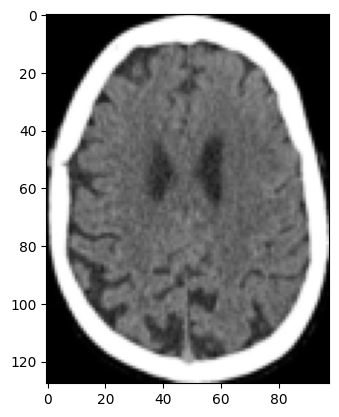

In [61]:
i = 12
img, label = images_labels[i]
show_tensor(img[0])

In [62]:
label

tensor([1])

In [63]:
# upload your own image
from src.CTDataModule import crop_black_and_white_loader
from torchvision import transforms
mode = "train"
num_img = "194"
test_image = f"/home/martinumer/IschemicData/{mode}/{mode}_stroke/{num_img}.jpg"
IMG_HEIGHT = 128
IMG_WIDTH = 98

short_img_pipeline = transforms.Compose([
    crop_black_and_white_loader,
            transforms.Resize(
                (IMG_HEIGHT, IMG_WIDTH), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
        ])

img = short_img_pipeline(test_image)
img = img.unsqueeze(dim=0)
label = torch.tensor([1])

In [64]:
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

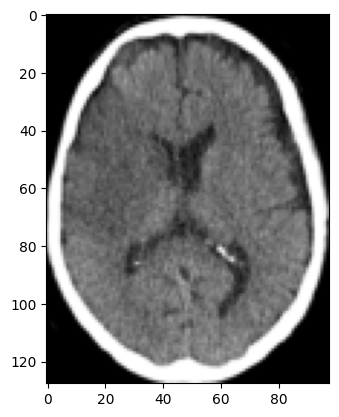

In [65]:
show_tensor(img[0])

In [66]:
# three_inception_blocks  = list(list(list(model.children())[0].children())[0].children())[:4]
# last_block  = list(list(list(model.children())[0].children())[0].children())[3]

three_inception_blocks  = list(list(list(model.children())[0].children())[0].children())[:3]
last_block  = list(list(list(model.children())[0].children())[0].children())[2]

In [67]:
second_big_block = list(model.children())[1]

In [68]:
# register hooks on each layer
hook1 = [Hook(layer) for layer in three_inception_blocks]
# hook2 = [Hook(layer) for layer in second_big_block]

In [69]:
model(img)

tensor([0.9937], grad_fn=<ReshapeAliasBackward0>)

In [70]:
hook1[0].output.shape

torch.Size([2, 256, 128, 49])

In [71]:
# hook2[0].output.shape

In [72]:
left_hemisphere =  hook1[0].output[0:img.shape[0]]
right_hemisphere =  hook1[0].output[img.shape[0]:]
left_hemisphere.shape

torch.Size([1, 256, 128, 49])

In [73]:
whole = torch.cat([left_hemisphere, right_hemisphere], dim=3)

In [74]:
whole.shape

torch.Size([1, 256, 128, 98])

In [75]:
scores_mean = F.softmax(whole.mean((0,2,3)))
scores_mean.shape

/tmp/ipykernel_4184836/2092496031.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores_mean = F.softmax(whole.mean((0,2,3)))


torch.Size([256])

In [76]:
activations = torch.zeros(whole.shape[0], 1, whole.shape[2], whole.shape[3])
for i in range(whole.shape[1]):
    activations += whole[:,i,:,:] * scores_mean[i]
activations = F.relu(activations)

In [77]:
activations = F.relu(activations)

In [78]:
activations.shape

torch.Size([1, 1, 128, 98])

In [79]:
heatmap = activations.squeeze()

## Normalize heatmap
heatmap = heatmap / torch.max(heatmap)

heatmap.shape

torch.Size([128, 98])

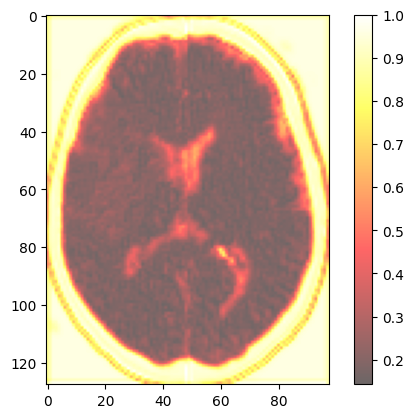

In [80]:
fig, ax = plt.subplots()

# plot the heatmap data on top of the original data
im = ax.imshow(heatmap.detach().numpy(), cmap='hot', alpha=0.6)

# add a colorbar for the heatmap
cbar = fig.colorbar(im)
plt.show()

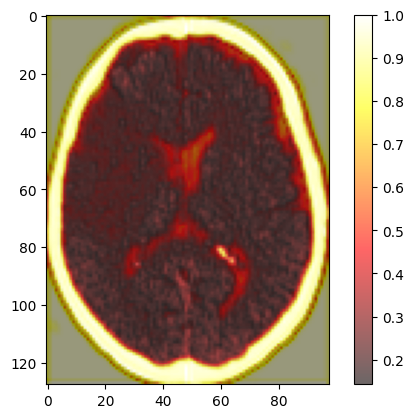

In [81]:

import matplotlib.pyplot as plt
import numpy as np

# create the first plot
fig, ax = plt.subplots()
ax.imshow(img[0].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')


# plot the heatmap data on top of the original data
im = ax.imshow(heatmap.detach().numpy(), cmap='hot', alpha=0.6)

# add a colorbar for the heatmap
cbar = fig.colorbar(im)

# show the plot
plt.show()



# Для разности (половинка мозга) (scorecam)

In [83]:
# last_squared_block = list(list(model.children())[-2].children())[-1]
last_squared_block = list(list(model.children())[-3].children())[-1]
last_squared_block

MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)

In [84]:
hook_half = Hook(last_squared_block)


In [85]:
model(img)

tensor([0.9937], grad_fn=<ReshapeAliasBackward0>)

In [86]:
hook_half.output.shape

torch.Size([1, 256, 43, 17])

In [87]:
output_mean = F.softmax(hook_half.output.mean((0,2,3)))
output_mean.shape

/tmp/ipykernel_4184836/2584013768.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_mean = F.softmax(hook_half.output.mean((0,2,3)))


torch.Size([256])

In [88]:
activations = torch.zeros(hook_half.output.shape[0], 1, hook_half.output.shape[2], hook_half.output.shape[3]) # torch.Size([1, 1, 43, 17])
for i in range(hook_half.output.shape[1]):
    activations += hook_half.output[:,i,:,:] * output_mean[i] # weighted feature maps
activations = F.relu(activations)
activations.shape

torch.Size([1, 1, 43, 17])

In [89]:
heatmap = activations.squeeze()

## Normalize heatmap
heatmap = heatmap / torch.max(heatmap)

heatmap.shape

torch.Size([43, 17])

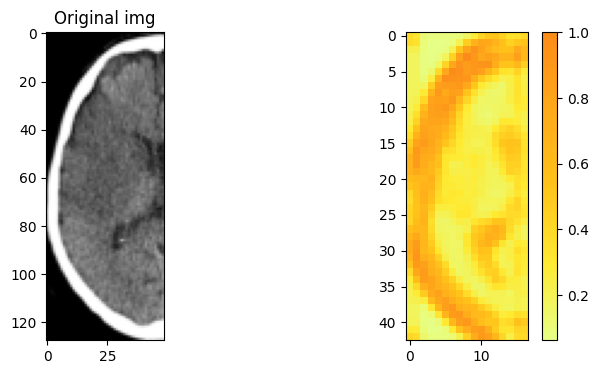

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(img[0][ :, :, :(98 // 2)].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax1.set_title('Original img')
# more orange means the highest values
im = ax2.imshow(heatmap.detach().numpy(), cmap='Wistia', alpha=0.9, interpolation='nearest')


cbar = fig.colorbar(im)
plt.show()


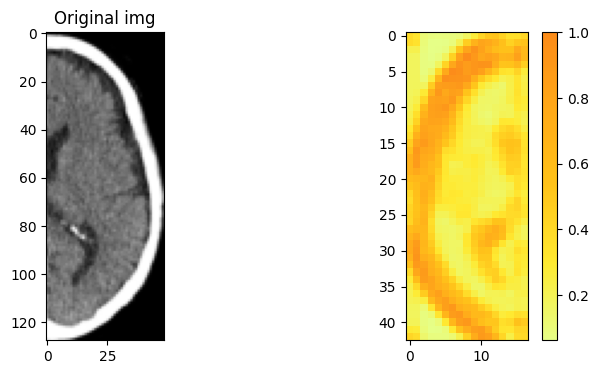

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(img[0][ :, :, (98 // 2):].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax1.set_title('Original img')
# more orange means the highest values
im = ax2.imshow(heatmap.detach().numpy(), cmap='Wistia', alpha=0.9, interpolation='nearest')


cbar = fig.colorbar(im)
plt.show()


# Для разности (половинка мозга) (gradcam)

In [27]:
# получаем выход слоёв ДО предсказания
x = list(model.children())[0](img)
# получаем активации иНТЕРЕСУЮЩЕГО слоя
layer_activations = list(model.children())[1](x)
layer_activations_flat = layer_activations.view(layer_activations.size()[0], -1)
layer_activations.grad_fn

In [28]:
# предсказание без функций активаций
pred = list(model.children())[2](layer_activations_flat)
pred

tensor([[6.6536]], grad_fn=<AddmmBackward0>)

In [29]:
from torch import autograd

grads = autograd.grad(pred, layer_activations) # ??

In [30]:
grads[0].shape

torch.Size([1, 256, 43, 17])

In [31]:
pooled_grads = grads[0].mean((0,2,3))

pooled_grads.shape

torch.Size([256])

In [32]:
conv_output = layer_activations.squeeze()

conv_output = F.relu(conv_output)

conv_output.shape



torch.Size([256, 43, 17])

In [119]:
for i in range(len(pooled_grads)):
    conv_output[i,:,:] *= pooled_grads[i]

In [33]:
heatmap2 = conv_output.mean(dim=0).squeeze()

## Normalize heatmap
heatmap2 = heatmap2 / torch.max(heatmap)

heatmap.shape

torch.Size([128, 98])

In [34]:
img.shape

torch.Size([1, 1, 128, 98])

In [35]:
heatmap.shape

torch.Size([128, 98])

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # create some data for the plots

# # create the first plot
# fig, ax1 = plt.subplots()
# ax1.imshow(img_i[0][ :, :, :(98 // 2)].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')

# # create the second plot and add it to the first plot
# ax2 = ax1.twinx()  # create a second y-axis that shares the same x-axis
# ax2.plot(x, y2, color='red')
# ax2.set_ylabel('y2')

# # show the plots
# plt.show()

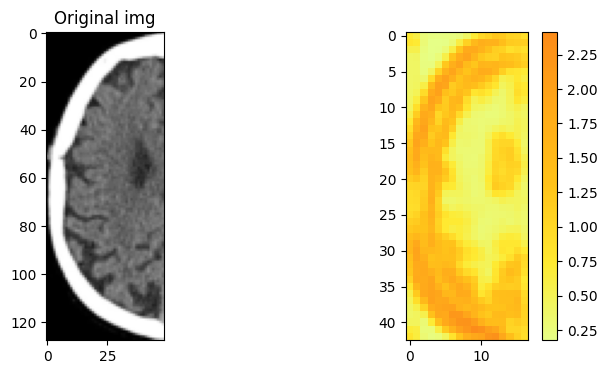

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(img[0][ :, :, :(98 // 2)].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax1.set_title('Original img')
# more orange means the highest values
im = ax2.imshow(heatmap2.detach().numpy(), cmap='Wistia', alpha=0.9, interpolation='nearest')


cbar = fig.colorbar(im)
plt.show()


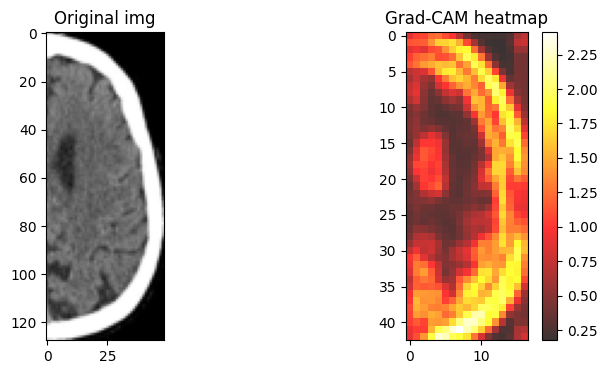

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(img[0][ :, :, (98 // 2):].permute(1, 2, 0)[:, :, 0].detach().numpy(), cmap='gray')
ax1.set_title('Original img')
# white means the highest values
im = ax2.imshow(torch.flip(heatmap2, dims=[1]).detach().numpy(), cmap='hot', alpha=0.8)
cbar = fig.colorbar(im)
ax2.set_title('Grad-CAM heatmap')
plt.show()


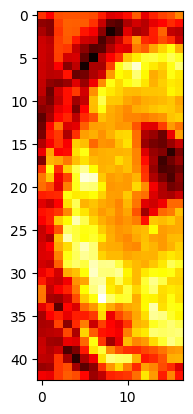

In [ ]:
plt.imshow(heatmap.detach().numpy(), cmap='hot')

In [ ]:
heatmap.shape

torch.Size([43, 17])

In [ ]:
img.shape

torch.Size([1, 1, 128, 98])

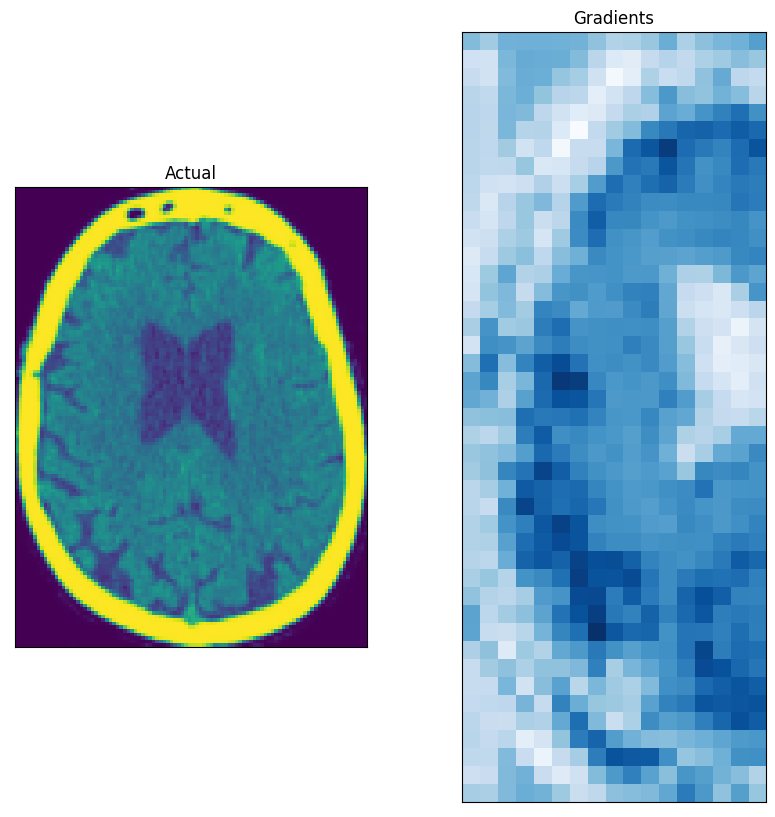

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_actual_and_heatmap(heatmap):
    cmap = matplotlib.cm.get_cmap("twilight_r")

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(121)
    ax1.imshow(img[0].numpy().squeeze());
    ax1.set_title("Actual");
    ax1.set_xticks([],[]);ax1.set_yticks([],[]);

    ax2 = fig.add_subplot(122)
    ax2.imshow(heatmap, cmap="Blues");
    ax2.set_title("Gradients");
    ax2.set_xticks([],[]);ax2.set_yticks([],[]);

plot_actual_and_heatmap(heatmap.detach())

<AxesSubplot: >

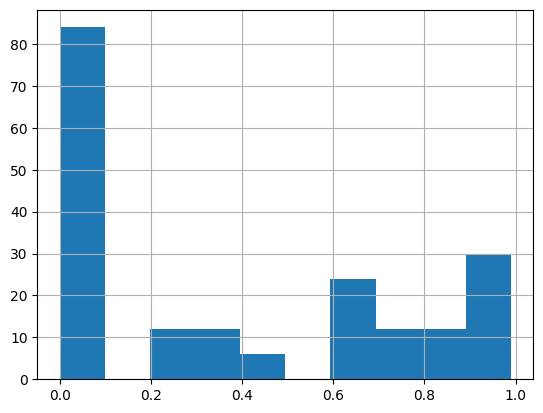

In [ ]:
labels_preds.y_pred.hist()

In [ ]:
threshold_best = model.find_threshold(labels_preds.y_pred,
                                          labels_preds.y_true)


/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/high_fly_bird/workspace/Ischemic_Stroke_Prediction/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
pred_bin = (labels_preds.y_pred > 0.5).astype(int)

In [ ]:
labels_preds['pred_bin'] = pred_bin

In [ ]:
labels_preds[(labels_preds.y_true==1)]

,y_true,y_pred,pred_bin


In [ ]:
from sklearn.metrics import f1_score,precision_score


f1_score(y_true=labels_preds.y_true, y_pred=pred_bin)
precision_score(y_true=labels_preds.y_true, y_pred=pred_bin)

0.0

In [ ]:
threshold_best

0.0

In [ ]:
labels_preds['pred_bin'] = (
        labels_preds.y_pred > threshold_best).astype(int)


In [ ]:
labels_preds

In [ ]:
model.get_layer

In [ ]:
gradModel = Model(
inputs=[model.inputs],
outputs=[model.get_layer(layer_name).output,
model.output])
with tf.GradientTape() as tape:
   # cast the image tensor to a float-32 data type, pass the
   # forward propagate the image through the gradient model, and grab the loss
   # associated with the specific class index
   inputs = tf.cast(img_array, tf.float32)
   (convOutputs, predictions) = gradModel(inputs)
   loss = predictions[:, 0]
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)
# compute the guided gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads
# the convolution and guided gradients have a batch dimension
# (which we don't need) so let's grab the volume itself and
# discard the batch
convOutputs = convOutputs[0]
guidedGrads = guidedGrads[0]
# compute the average of the gradient values, and using them
# as weights, compute the ponderation of the filters with
# respect to the weights
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (img_array.shape[2], img_array.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))
# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer
numer = heatmap - np.min(heatmap)
denom = (heatmap.max() - heatmap.min()) + eps
heatmap = numer / denom